General notes:
- This is highlighting a further point that the perturbation stuff is really about full unitary/super op simulation. The benefits of this approach are most stark in that regime - for single state simulation it seems to not provide enough of a speed up (i.e. for unitary simulation we can observe more than 10x speed up (with right parameters I've seen more than 25x), but for single input state simulation it's more like 2-3x, which I don't personally think is enough to justify its use given the compilation cost)


3 is control, 5 is target

steps:
- compute the dressed frequencies

pulses:
- CR is gaussian square on control at "freq of target"
- Rotary echo is on target with "freq of target"
- Bipolar guassian square/antisymmetric thing is on target with "freq of target"

# gaussian square:

```
if params["type"]=="GaussianSquare":
    T=self.params["twidth"]; sigma=self.params["sigma"];risefall=self.params['risefall']
    C=np.exp(-(2*risefall*sigma)**2/(8*sigma**2));
    den=(np.sqrt(np.pi*2*sigma**2)*sp.special.erf(2*risefall*sigma/(np.sqrt(8)*sigma))-2*risefall*sigma*C)
    
    if t<risefall*sigma:
        temp=self.params["amp"]*(np.exp(-(t-sigma*risefall)**2/(2*sigma**2))-C)/den
        return temp
    elif T-t<risefall*sigma: 
        return self.params["amp"]*(np.exp(-(T-t-sigma*risefall)**2/(2*sigma**2))-C)/den
    else: 
        return self.params["amp"]*(1-C)/den

self.params["type"]=="BipolarGaussianSquare":
T=self.params["twidth"];sigma=self.params["sigma"];risefall=self.params['risefall']
C=np.exp(-(2*risefall*sigma)**2/(8*sigma**2));
den=(np.sqrt(np.pi*2*sigma**2)*sp.special.erf(2*risefall*sigma/(np.sqrt(8)*sigma))-2*risefall*sigma*C)
if t<risefall*sigma:
    temp=self.params["amp"]*(np.exp(-(t-sigma*risefall)**2/(2*sigma**2))-C)/den
    return temp
elif t<T/2-risefall*sigma: 
    return self.params["amp"]*(1-C)/den
elif t<T/2: 
    return self.params["amp"]*(np.exp(-(T/2-t-sigma*risefall)**2/(2*sigma**2))-C)/den
elif t<T/2+risefall*sigma: 
    return -1*self.params["amp"]*(np.exp(-((t-T/2)-sigma*risefall)**2/(2*sigma**2))-C)/den
elif t<T-risefall*sigma: 
    return -1*self.params["amp"]*(1-C)/den
elif T-t<risefall*sigma: 
    return -1*self.params["amp"]*(np.exp(-(T-t-sigma*risefall)**2/(2*sigma**2))-C)/den
```

In [1]:
from time import time

import numpy as np
import scipy as sp

import jax.numpy as jnp
from jax import jit, grad, value_and_grad, vmap
from jax.scipy.special import erf
from jax.lax import cond, associative_scan
from jax.scipy.linalg import expm as jexpm
from jax.config import config
from jax.ops import index_update
config.update("jax_enable_x64", True)

from qiskit.quantum_info import Operator

from qiskit_dynamics.signals import Signal
from qiskit_dynamics.models import HamiltonianModel
from qiskit_dynamics import solve_lmde
from qiskit_dynamics_internal.perturbation.perturbative_solvers import PerturbativeSolver

from qiskit_dynamics import dispatch
from qiskit_dynamics.dispatch import Array

dispatch.set_default_backend('jax')

In [2]:
def gaussian_square(t, amp, sigma, risefall, T):
    """Compute gaussian square with parameters."""
    # are the sigmas redundant in the following formulas? Aside from the first term in 
    # den it seems to be getting divided out
    t = Array(t).data
    C = jnp.exp(-(2*risefall*sigma)**2/(8*sigma**2))
    den = (jnp.sqrt(jnp.pi*2*sigma**2)*erf(2*risefall*sigma/(jnp.sqrt(8)*sigma))-2*risefall*sigma*C)
    return amp * cond(t < risefall * sigma,
                      lambda s: (jnp.exp(-(s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                      lambda s: cond(T - t < risefall * sigma,
                                     lambda u: (jnp.exp(-(T-u-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                     lambda u: (1-C)/den,
                                     t),
                      t)

def bipolar_gaussian_square(t, amp, sigma, risefall, T):
    t = Array(t).data
    unipolar = lambda s: gaussian_square(s, amp, sigma, risefall, T/2)
    return cond(t < T/2,
                unipolar,
                lambda s: -unipolar(s - T/2),
                t)

In [3]:
T = 300.
risefall = 2.
sigma = 15.
amp=4.

test = jnp.vectorize(lambda t: bipolar_gaussian_square(t, amp, sigma, risefall, T))

sig = Signal(test)

In [4]:
def pulseFunction(t,amp,T,sigma,risefall,shape="GaussianSquare"):
    if t>T: return 0
    elif shape=="GaussianSquare":
      C=np.exp(-(2*risefall*sigma)**2/(8*sigma**2));
      den=(np.sqrt(np.pi*2*sigma**2)*sp.special.erf(2*risefall*sigma/(np.sqrt(8)*sigma))-2*risefall*sigma*C)
      if t<risefall*sigma:
        temp=amp*(np.exp(-(t-sigma*risefall)**2/(2*sigma**2))-C)/den
        return temp
      elif T-t<risefall*sigma: return amp*(np.exp(-(T-t-sigma*risefall)**2/(2*sigma**2))-C)/den
      else: return amp*(1-C)/den
    elif shape=="BipolarGaussianSquare":
      C=np.exp(-(2*risefall*sigma)**2/(8*sigma**2));
      den=(np.sqrt(np.pi*2*sigma**2)*sp.special.erf(2*risefall*sigma/(np.sqrt(8)*sigma))-2*risefall*sigma*C)
      if t<risefall*sigma:
        temp=amp*(np.exp(-(t-sigma*risefall)**2/(2*sigma**2))-C)/den
        return temp
      elif t<T/2-risefall*sigma: return amp*(1-C)/den
      elif t<T/2: return amp*(np.exp(-(T/2-t-sigma*risefall)**2/(2*sigma**2))-C)/den
      elif t<T/2+risefall*sigma: return -1*amp*(np.exp(-((t-T/2)-sigma*risefall)**2/(2*sigma**2))-C)/den
      elif t<T-risefall*sigma: return -1*amp*(1-C)/den
      elif T-t<risefall*sigma: return -1*amp*(np.exp(-(T-t-sigma*risefall)**2/(2*sigma**2))-C)/den
      else: return 0
    else: raise Exception('type: ' + shape + ' is unsupported :(')

In [5]:
sig2 = Signal(np.vectorize(lambda t: pulseFunction(t, amp, T, sigma, risefall, "BipolarGaussianSquare")))

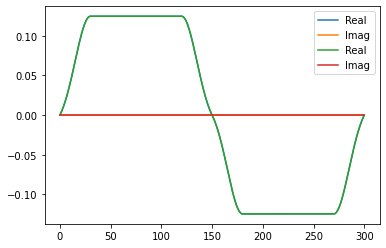

In [6]:
sig.draw(0, 300, 500, function='envelope')
sig2.draw(0, 300, 500, function='envelope')

Input data

```
inputDict = {'systemDict': {'elementDict':
{0: {'label': 'q3', 'dim': 5, 'freq': 5.105,'anharmonicity': -0.33534, 'T1': 100.17, 'T2': 71.25},
1: {'label': 'q5', 'dim': 5, 'freq': 5.033, 'anharmonicity': -0.33834, 'T1': 79.34, 'T2': 71.89}},
'couplingDict': {0: {'label1': 'q10', 'label2': 'q12', 'strength': 0.002}}},
'gateDict': {'qubits': ['q3', 'q5'], 'sigma': 15, 'risefall': 2, 'gatetime'300}
```

In [7]:
w_c = 2 * np.pi * 5.105
w_t = 2 * np.pi * 5.033
alpha_c = 2 * np.pi * (-0.33534)
alpha_t = 2 * np.pi * (-0.33834)
J = 2 * np.pi * 0.002

dim = 5

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = a.transpose()
N = np.diag(np.arange(dim))
ident = np.eye(dim)
ident2 = np.eye(dim**2)

# operators on the control qubit (first tensor factor)
a0 = np.kron(a, ident)
adag0 = np.kron(adag, ident)
N0 = np.kron(N, ident)

# operators on the target qubit (first tensor factor)
a1 = np.kron(ident, a)
adag1 = np.kron(ident, adag)
N1 = np.kron(ident, N)

In [8]:
H0 = (w_c * N0 + 0.5 * alpha_c * N0 @ (N0 - ident2)
      + w_t * N1 + 0.5 * alpha_t * N1 @ (N1 - ident2)
      + J * (a0 @ adag1 + adag0 @ a1))
Hdc = 2 * np.pi * (a0 + adag0)
Hdt = 2 * np.pi * (a1 + adag1)

In [9]:
def basis_vec(ind, dimension):
    vec = np.zeros(dimension, dtype=complex)
    vec[ind] = 1.
    return vec

def two_q_basis_vec(inda, indb, dimension):
    vec_a = basis_vec(inda, dimension)
    vec_b = basis_vec(indb, dimension)
    return np.kron(vec_a, vec_b)

def get_dressed_state_index(inda, indb, dimension, evectors):
    b_vec = two_q_basis_vec(inda, indb, dimension)
    overlaps = np.abs(evectors @ b_vec)
    return overlaps.argmax()

def get_dressed_state_and_energy(inda, indb, dimension, evecs):
    ind = get_dressed_state_index(inda, indb, dimension, evecs)
    return evals[ind], evecs[ind]

In [10]:
evals, B = jnp.linalg.eigh(H0)
Badj = B.conj().transpose()

E00, dressed00 = get_dressed_state_and_energy(0, 0, dim, B.transpose())
E01, dressed01 = get_dressed_state_and_energy(0, 1, dim, B.transpose())
E10, dressed10 = get_dressed_state_and_energy(1, 0, dim, B.transpose())
E11, dressed11 = get_dressed_state_and_energy(1, 1, dim, B.transpose())

In [11]:
# "target dressed frequency"
v_t = E01 / (2 * np.pi)

In [12]:
v_t

DeviceArray(5.03294449, dtype=float64)

In [13]:
H0_B = Badj @ H0 @ B
Hdc_B = Badj @ Hdc @ B
Hdt_B = Badj @ Hdt @ B

In [14]:
init_amps = np.array([1.4, 0., 0.3])
init_phases = np.array([0., 0., 0.])

In [15]:
idx00 = 0
idx01 = get_dressed_state_index(0, 1, dim, B.transpose())
idx10 = get_dressed_state_index(1, 0, dim, B.transpose())
idx11 = get_dressed_state_index(1, 1, dim, B.transpose())

e00 = np.zeros(dim**2, dtype=complex)
e00[0] = 1.
e10 = np.zeros(dim**2, dtype=complex)
e10[idx10] = 1.
e01 = np.zeros(dim**2, dtype=complex)
e01[idx01] = 1.
e11 = np.zeros(dim**2, dtype=complex)
e11[idx11] = 1.

# set up observables
S = np.array([e00, e01, e10, e11]).transpose()
Sdag = S.conj().transpose()

II = S @ Sdag
IX = S @ np.array(Operator.from_label('IX')) @ Sdag
IY = S @ np.array(Operator.from_label('IY')) @ Sdag
IZ = S @ np.array(Operator.from_label('IZ')) @ Sdag
XI = S @ np.array(Operator.from_label('XI')) @ Sdag
XX = S @ np.array(Operator.from_label('XX')) @ Sdag
XY = S @ np.array(Operator.from_label('XY')) @ Sdag
XZ = S @ np.array(Operator.from_label('XZ')) @ Sdag
YI = S @ np.array(Operator.from_label('YI')) @ Sdag
YX = S @ np.array(Operator.from_label('YX')) @ Sdag
YY = S @ np.array(Operator.from_label('YY')) @ Sdag
YZ = S @ np.array(Operator.from_label('YZ')) @ Sdag
ZI = S @ np.array(Operator.from_label('ZI')) @ Sdag
ZX = S @ np.array(Operator.from_label('ZX')) @ Sdag
ZY = S @ np.array(Operator.from_label('ZY')) @ Sdag
ZZ = S @ np.array(Operator.from_label('ZZ')) @ Sdag

In [16]:
e11

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j])

# 1.1 sim function

In [17]:
ham = HamiltonianModel(operators=[H0_B, Hdc_B, Hdt_B])
#ham.frame = H0_B

y0 = np.eye(dim**2, dtype=complex)

def full_sim(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    ham_copy = ham.copy()
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    ham_copy.signals = [1., cr_signal, target_signal]
    ham_copy.frame = ham_copy.drift
    #import pdb; pdb.set_trace()
    results = solve_lmde(ham_copy, 
                     t_span=[0, T],
                     y0=y0,
                     method='jax_odeint',
                     atol=1e-8,
                     rtol=1e-8)
    
    U = results.y[-1]

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


In [18]:
target = S @ jexpm(-1j * np.array(Operator.from_label('ZX')) * jnp.pi / 4) @ Sdag
target_conj = target.conj()

def fidelity(U):
    return jnp.abs(jnp.sum(target_conj * U))**2 / (4**2)

In [19]:
def obj(x):
    amps = x[0:3]
    phases = x[3:6]
    pre_rot = x[6:8]
    post_rot = x[8:]
    
    U = full_sim(amps, phases, pre_rot, post_rot)
    
    return 1 - fidelity(U)

In [20]:
from scipy.optimize import minimize

bipolar amp

In [21]:
jit_obj = jit(obj)
grad_obj = jit(value_and_grad(obj))

x0=[1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.]

start = time()
# needs x vals need to be 1d
res = minimize(grad_obj, x0=x0, method='BFGS', jac=True)
print('time taken: ' + str(time() - start))

print(res)

time taken: 1588.8131248950958
      fun: 0.00016131728370660792
 hess_inv: array([[ 1.89480353e+02, -1.69664776e+00, -1.82478559e+00,
        -7.02321102e+01,  3.07851415e-01,  5.91981037e+01,
        -1.16125962e+01,  1.44291278e+03,  1.15683739e+01,
         1.44291278e+03],
       [-1.69664776e+00,  3.24061643e-02,  2.43973720e-02,
         3.99975749e-01,  5.65363169e-01, -7.53808426e-01,
         2.22697415e-01, -1.29187287e+01, -2.15981420e-01,
        -1.29187287e+01],
       [-1.82478559e+00,  2.43973720e-02,  9.06227375e-02,
         5.66573595e-01,  2.83287060e-01, -6.52914029e-01,
         2.06647693e-01, -1.38927261e+01, -2.04053312e-01,
        -1.38927261e+01],
       [-7.02321102e+01,  3.99975749e-01,  5.66573595e-01,
         3.00779090e+01, -8.32608723e+00, -1.85439303e+01,
         2.47563359e+00, -5.34820368e+02, -2.57967438e+00,
        -5.34820368e+02],
       [ 3.07851415e-01,  5.65363169e-01,  2.83287060e-01,
        -8.32608723e+00,  2.14361614e+01, -7.92904317

## Attempt with Dyson solver

In [22]:
# system information
generator_decomp = [-1j  * Hdc_B, -1j * Hdt_B]
carrier_freqs = [v_t, v_t]
frame_operator = -1j * H0_B

# approximation specification:
# chebyshev order to use
polynomial_degrees = [1, 1]
# Dyson series order to go to
perturbation_order = 6


# we will use 
n_steps = 600
dt = T / n_steps

start = time()
dyson_solver_jax = PerturbativeSolver(generator_decomp, 
                                       frame_operator,
                                       dt,
                                       carrier_freqs,
                                       polynomial_degrees,
                                       perturbation_method='dyson',
                                       perturbation_order=perturbation_order,
                                       method='jax_odeint',
                                       atol=1e-8,
                                       rtol=1e-8)
print(time() - start)

680.0120961666107


In [31]:
y0 = np.eye(dim**2, dtype=complex)

def dyson_sim(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    ham_copy = ham.copy()
    cr_signal = Signal(jnp.vectorize(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T)), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(jnp.vectorize(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T)), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(jnp.vectorize(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T)), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    #import pdb; pdb.set_trace()
    U = dyson_solver_jax.solve([cr_signal, target_signal], y0, 0, n_steps)

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


In [32]:
def dyson_obj(x):
    amps = x[0:3]
    phases = x[3:6]
    pre_rot = x[6:8]
    post_rot = x[8:]

    U = dyson_sim(amps, phases, pre_rot, post_rot)
    
    return 1 - fidelity(U)

In [33]:
jit_dyson_obj = jit(dyson_obj)
grad_dyson_obj = jit(value_and_grad(dyson_obj))

x0=[1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.]

start = time()
# needs x vals need to be 1d
perturb_res = minimize(grad_dyson_obj, x0=x0, method='BFGS', jac=True)
print('time taken: ' + str(time() - start))

print(perturb_res)

time taken: 32.80638384819031
      fun: 0.00016710781572526479
 hess_inv: array([[ 2.06302483e+02, -1.96360697e+00, -2.13008545e+00,
        -7.61686399e+01, -2.00429515e+00,  6.55459082e+01,
        -1.35511594e+01,  1.56977713e+03,  1.31079426e+01,
         1.56977713e+03],
       [-1.96360697e+00,  3.94612096e-02,  2.61127786e-02,
         4.39563030e-01,  7.32094819e-01, -9.05783271e-01,
         2.86473779e-01, -1.49410460e+01, -2.58083477e-01,
        -1.49410460e+01],
       [-2.13008545e+00,  2.61127786e-02,  9.40836402e-02,
         7.24839321e-01,  2.22571271e-01, -7.39505053e-01,
         2.43816064e-01, -1.62076252e+01, -1.87504676e-01,
        -1.62076252e+01],
       [-7.61686399e+01,  4.39563030e-01,  7.24839321e-01,
         3.30834846e+01, -9.84461768e+00, -1.98254523e+01,
         2.55235691e+00, -5.79572608e+02, -2.81033616e+00,
        -5.79572608e+02],
       [-2.00429515e+00,  7.32094819e-01,  2.22571271e-01,
        -9.84461768e+00,  2.76514840e+01, -1.12125282e

In [34]:
print(dyson_obj(res.x))
print(dyson_obj(perturb_res.x))

0.00016710849668755134
0.00016710781572504274


In [35]:
print(obj(res.x))
print(obj(perturb_res.x))

0.00016131728370993859
0.00016131772719940596


In [36]:
start = time()
out = grad_dyson_obj(res.x)[1].block_until_ready()
print(time() - start)

0.21885895729064941


In [37]:
# Emily's optimization parameters
#x = [0.8928422518670537, -0.006545166015625003, 0.30030852556228615]
#[0, 0.15063515396118174, -0.0011186523437500052]

x2 = np.array([0.8928422518670537, -0.006545166015625003, 0.30030852556228615,
               0, 0.15063515396118174, -0.0011186523437500052,
              0., 0., 0., 0.])

In [38]:
obj(x2)

DeviceArray(0.59893858, dtype=float64)

In [39]:
# 0.59971594

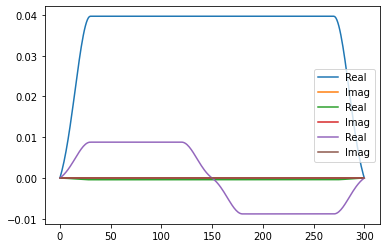

In [40]:
amps = perturb_res.x[0:3]
phases = perturb_res.x[3:6]
pre_rot = perturb_res.x[6:8]
post_rot = perturb_res.x[8:]

cr_signal = Signal(jnp.vectorize(lambda t: gaussian_square(t, amps[0], sigma, risefall, T)), 
                   carrier_freq=v_t, 
                   phase=phases[0])
rotary_signal = Signal(jnp.vectorize(lambda t: gaussian_square(t, amps[1], sigma, risefall, T)), 
                       carrier_freq=v_t,
                       phase=phases[1])
bipolar_signal = Signal(jnp.vectorize(lambda t: bipolar_gaussian_square(t, amps[2], sigma, risefall, T)), 
                        carrier_freq=v_t,
                        phase=phases[2])

cr_signal.draw(0, T, 300, function='envelope')
rotary_signal.draw(0, T, 300, function='envelope')
bipolar_signal.draw(0, T, 300, function='envelope')

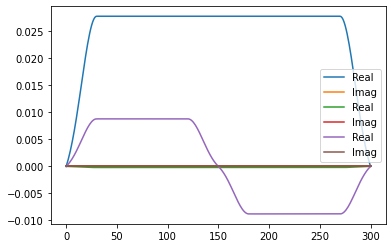

In [41]:
amps2 = x2[0:3]
phases2 = x2[3:6]
pre_rot2 = x2[6:8]
post_rot2 = x2[8:]

cr_signal2 = Signal(jnp.vectorize(lambda t: gaussian_square(t, amps2[0], sigma, risefall, T)), 
                   carrier_freq=v_t, 
                   phase=phases2[0])
rotary_signal2 = Signal(jnp.vectorize(lambda t: gaussian_square(t, amps2[1], sigma, risefall, T)), 
                       carrier_freq=v_t,
                       phase=phases2[1])
bipolar_signal2 = Signal(jnp.vectorize(lambda t: bipolar_gaussian_square(t, amps[2], sigma, risefall, T)), 
                        carrier_freq=v_t,
                        phase=phases2[2])

cr_signal2.draw(0, T, 300, function='envelope')
rotary_signal2.draw(0, T, 300, function='envelope')
bipolar_signal2.draw(0, T, 300, function='envelope')

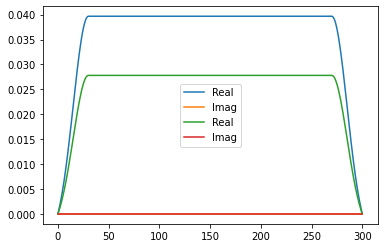

In [42]:
cr_signal.draw(0, T, 300, function='envelope')
cr_signal2.draw(0, T, 300, function='envelope')

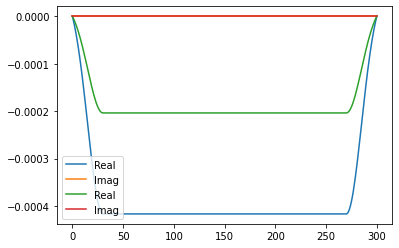

In [43]:
rotary_signal.draw(0, T, 300, function='envelope')
rotary_signal2.draw(0, T, 300, function='envelope')

0.49788821998108584
-0.0011186523437500052


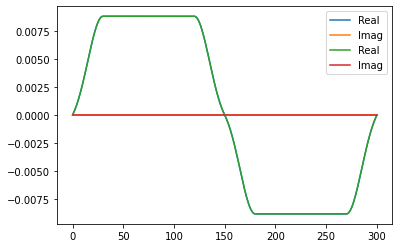

In [44]:
bipolar_signal.draw(0, T, 300, function='envelope')
print(bipolar_signal.phase)
bipolar_signal2.draw(0, T, 300, function='envelope')
print(bipolar_signal2.phase)

In [45]:
ham = HamiltonianModel(operators=[H0_B, Hdc_B, Hdt_B])
#ham.frame = H0_B

y0 = np.eye(dim**2, dtype=complex)

def full_sim_high_tol(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    ham_copy = ham.copy()
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    ham_copy.signals = [1., cr_signal, target_signal]
    ham_copy.frame = ham_copy.drift
    #import pdb; pdb.set_trace()
    results = solve_lmde(ham_copy, 
                     t_span=[0, T],
                     y0=y0,
                     method='jax_odeint',
                     atol=1e-13,
                     rtol=1e-13)
    
    U = results.y[-1]

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


In [46]:
def obj_high_tol(x):
    amps = x[0:3]
    phases = x[3:6]
    pre_rot = x[6:8]
    post_rot = x[8:]
    
    U = full_sim_high_tol(amps, phases, pre_rot, post_rot)
    
    return 1 - fidelity(U)

In [47]:
obj_high_tol(x2)
# 0.59971594

DeviceArray(0.59894059, dtype=float64)

Speed comparisons

In [48]:
start = time()
grad_obj(res.x)[0].block_until_ready()
print(time() - start)

16.790015935897827


In [49]:
start = time()
grad_dyson_obj(res.x)[0].block_until_ready()
print(time() - start)

0.23738694190979004


In [50]:
# roughly
17 / 0.3

56.66666666666667

## Parallelizing standard ODE routine

I think for more fair speed comparison we should parallelize the standard ODE execution to try to make use of more cores.

In [51]:
ham = HamiltonianModel(operators=[H0_B, Hdc_B, Hdt_B])
#ham.frame = H0_B
n_steps = 100


y0 = np.eye(dim**2, dtype=complex)

def full_sim_parallel(amps, phases, pre_rot, post_rot):
    cr_amp = amps[0]
    cr_phase = phases[0]
    rotary_amp = amps[1]
    rotary_phase = phases[1]
    bipolar_amp = amps[2] 
    bipolar_phase = phases[2]
    ham_copy = ham.copy()
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    ham_copy.signals = [1., cr_signal, target_signal]
    ham_copy.frame = ham_copy.drift
    
    dt = T / n_steps
    def single_sim(k):
        return solve_lmde(ham_copy, 
                     t_span=[k * dt, (k + 1) * dt],
                     y0=y0,
                     method='jax_odeint',
                     atol=1e-8,
                     rtol=1e-8).y[-1]
    
    Us = vmap(single_sim)(jnp.flip(jnp.arange(n_steps)))

    U = associative_scan(jnp.matmul, Us, axis=0)[-1]

    return jexpm(-1j * (post_rot[0] * IZ + post_rot[1] * ZI)) @ U @ jexpm(-1j * (pre_rot[0] * IZ + pre_rot[1] * ZI))


In [52]:
def obj_parallel(x):
    amps = x[0:3]
    phases = x[3:7]
    pre_rot = x[7:9]
    post_rot = x[9:]
    
    U = full_sim_parallel(amps, phases, pre_rot, post_rot)
    
    return 1 - fidelity(U)

In [53]:
jit_obj_parallel = jit(obj_parallel)
grad_obj_parallel = jit(value_and_grad(obj_parallel))

x0=[1.4, 0., 0.3, 0., 0., 0., 0., 0., 0., 0.]

#start = time()
# needs x vals need to be 1d
#res = minimize(grad_obj_parallel, x0=x0, method='BFGS', jac=True)
#print('time taken: ' + str(time() - start))

#print(res)

In [54]:
start = time()
grad_obj_parallel(res.x)[0].block_until_ready()
print(time() - start)

47.6769380569458


Some weird stuff is going on here... I think this is the `vmap` + `odeint` issue - it won't use nearly as much CPU as the dysolve version - doesn't seem to matter how many steps I put, but adding more steps even makes things slower.